In [1]:
using TuringModels
gr(size=(500,500));

Turing.setadbackend(:reverse_diff);
Turing.turnprogress(false);

ProjDir = rel_path_t("..", "scripts", "04")
cd(ProjDir)

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /Users/rob/.julia/packages/Turing/FTRCE/src/Turing.jl:24


### snippet 4.43

In [2]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults and center the weight observations

In [3]:
df2 = filter(row -> row[:age] >= 18, df);
mean_weight = mean(df2[:weight]);
df2[:weight_c] = df2[:weight] .- mean_weight;
first(df2, 5)

,height,weight,age,male,weight_c
,Float64⍰,Float64⍰,Float64⍰,Int64⍰,Float64
1,151.765,47.8256,63.0,1,2.83512
2,139.7,36.4858,63.0,0,-8.50468
3,136.525,31.8648,65.0,0,-13.1256
4,156.845,53.0419,41.0,1,8.05143
5,145.415,41.2769,51.0,0,-3.71361


Extract variables for Turing model

In [4]:
y = convert(Vector{Float64}, df2[:height]);
x = convert(Vector{Float64}, df2[:weight_c]);

Define the regression model

In [5]:
@model line(y, x) = begin
    #priors
    alpha ~ Normal(178.0, 100.0)
    beta ~ Normal(0.0, 10.0)
    s ~ Uniform(0, 50)

    #model
    mu = alpha .+ beta*x
    for i in 1:length(y)
      y[i] ~ Normal(mu[i], s)
    end
end;

Draw the samples

In [6]:
samples = 5000
adapt_cycles = 1000

@time chn = sample(line(y, x), Turing.NUTS(samples, adapt_cycles, 0.65));
draws = adapt_cycles+1:samples

┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/FTRCE/src/inference/support/hmc_core.jl:240
[NUTS{Turing.Core.FluxTrackerAD,Union{}}] found initial ϵ: 0.8
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/FTRCE/src/inference/support/hmc_core.jl:235
┌ Warning: 11.508408076621421 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/FTRCE/src/inference/adapt/stepsize.jl:96
┌ Info:  Adapted ϵ = 0.03799281899182767, std = [1.0, 1.0, 1.0]; 1000 iterations is used for adaption.
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/FTRCE/src/inference/adapt/adapt.jl:91
[NUTS] Finished with
  Running time        = 754.4604380890001;
  #lf / sample        = 0.0;
  #evals / sample     = 27.2008;
  pre-cond. metric    = [1.0, 1.0, 1.0].
756.488088 seconds (4.51 G allocations: 295.219 GiB, 17.06% gc time)


1001:5000

Describe the chain result

In [7]:
describe(chn)

Iterations = 1:5000
Thinning interval = 1
Chains = 1
Samples per chain = 5000

Empirical Posterior Estimates:
              Mean           SD        Naive SE       MCSE         ESS    
   alpha   154.29921292  4.948923125 0.0699883420 0.3009051731  270.496785
    beta     0.90262873  0.077560341 0.0010968689 0.0023154723 1122.019049
  lf_num     0.00000000  0.000000000 0.0000000000 0.0000000000         NaN
       s     5.39413715  3.127979711 0.0442363133 0.2893004468  116.904074
 elapsed     0.15089209  0.136859001 0.0019354786 0.0033650591 1654.098431
 epsilon     0.04294097  0.081336158 0.0011502670 0.0027752294  858.953284
      lp -1091.32238728 78.020032872 1.1033698862 7.6074563413  105.180037
eval_num    27.20080000 22.002374878 0.3111605696 0.4373090104 2531.408700
  lf_eps     0.04294097  0.081336158 0.0011502670 0.0027752294  858.953284

Quantiles:
               2.5%           25.0%           50.0%          75.0%          97.5%    
   alpha   154.030732571   154.410525855  

Show corrected results (drop adaptation samples)

In [8]:
chn2 = MCMCChain.Chains(chn.value[draws,:,:], names=chn.names)

Object of type "Chains{Float64}"

Iterations = 1:4000
Thinning interval = 1
Chains = 1
Samples per chain = 4000

Union{Missing, Float64}[154.455 0.909104 … 10.0 0.0379928; 154.468 0.880526 … 22.0 0.0379928; … ; 154.324 0.873847 … 10.0 0.0379928; 154.363 0.921118 … 10.0 0.0379928]

Look at the proper draws (in corrected chn2)

In [9]:
describe(chn2)

Iterations = 1:4000
Thinning interval = 1
Chains = 1
Samples per chain = 4000

Empirical Posterior Estimates:
              Mean                   SD                       Naive SE                       MCSE                ESS    
   alpha   154.60415099  0.276207911721321419662445 0.00436723054399047305035308 0.0091912944078588083851589  903.064716
    beta     0.90475927  0.042462427425804881442328 0.00067138992822571947824417 0.0005469736212745373183514 4000.000000
  lf_num     0.00000000  0.000000000000000000000000 0.00000000000000000000000000 0.0000000000000000000000000         NaN
       s     5.10890527  0.195715574637163464144507 0.00309453494711059515914764 0.0024688309060914787398944 4000.000000
 elapsed     0.15190197  0.126719298445957195831113 0.00200360803293930063093131 0.0034724400541447123999528 1331.729455
 epsilon     0.03799282  0.000000000000000006939761 0.00000000000000000010972726 0.0000000000000000011111123   39.009752
      lp -1083.72037589  1.2420102314353440

Compare with a previous result

In [10]:
clip_43s_example_output = "

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
         Mean        SD       Naive SE       MCSE      ESS
alpha 154.597086 0.27326431 0.0043206882 0.0036304132 1000
 beta   0.906380 0.04143488 0.0006551430 0.0006994720 1000
sigma   5.106643 0.19345409 0.0030587777 0.0032035103 1000

Quantiles:
          2.5%       25.0%       50.0%       75.0%       97.5%
alpha 154.0610000 154.4150000 154.5980000 154.7812500 155.1260000
 beta   0.8255494   0.8790695   0.9057435   0.9336445   0.9882981
sigma   4.7524368   4.9683400   5.0994450   5.2353100   5.5090128
";

Plot the regerssion line and observations

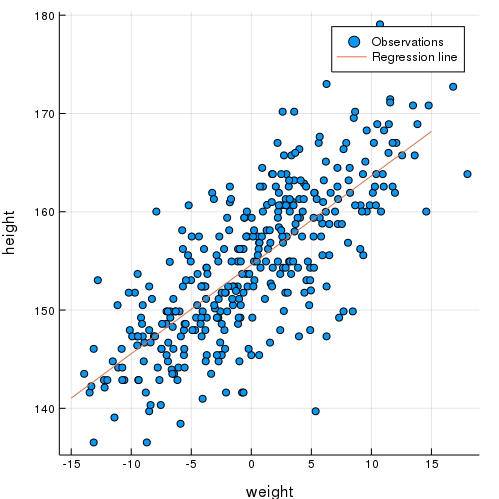

In [11]:
scatter(x, y, lab="Observations", xlab="weight", ylab="height")
xi = -15.0:0.1:15.0
yi = mean(chn2.value[:,1,:]) .+ mean(chn2.value[:, 2, :])*xi
plot!(xi, yi, lab="Regression line")

End of `clip_43t.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*